## Global Feature Importance

In [1]:
import pandas as pd
import numpy as np
import time

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import balanced_accuracy_score

save_figures = False
figure_path = "../figures/evaluation/"
# df_init = pd.read_parquet("../data/init.parquet")
# df_before = pd.read_parquet("../data/before_split.parquet")
# df_train = pd.read_parquet("../data/prep_train.parquet")
# df_val = pd.read_parquet("../data/prep_val.parquet")
# df_test = pd.read_parquet("../data/prep_test.parquet")
# df_tt_train = pd.read_parquet("../data/prep_tt_train.parquet")
# df_tt_test = pd.read_parquet("../data/prep_tt_test.parquet")
df_all = pd.read_parquet("../data/prep_all.parquet")

In [2]:
df_all.head()

,Year_Y2015,Year_Y2016,Country_England,Country_Wales,Supermarket_Asda,Supermarket_Tesco Extra,Supermarket_Tesco Metro,Supermarket_Waitrose,Time_Evening,Time_Morning,...,YearCountryAge_Y2016EnglandAge_g2,YearCountryAge_Y2016EnglandAge_g3,YearCountryAge_Y2016WalesAge_g1,YearCountryAge_Y2016WalesAge_g2,YearCountryAge_Y2016WalesAge_g3,YearCountryAge_nan,ObsSize,FemaleN,MaleN,y
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-0.471136,-1.156159,0.871226,1
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-0.471136,-1.156159,0.871226,1
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,-0.471136,0.583858,-0.993069,1
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.811174,2.323876,-0.993069,1
4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,-0.471136,0.583858,-0.993069,1


In [3]:
X_all = df_all.iloc[:,0:-1].to_numpy()
y_all = df_all["y"].to_numpy()

### Measure 3: Permutation Importance

In [4]:
feature_names = df_all.columns[0:-1]

In [5]:
random_state = 132
Dtree = DecisionTreeClassifier()
Ada_grid = AdaBoostClassifier(base_estimator = Dtree, 
                              random_state = random_state)
Ada_grid

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=132)

In [6]:
params_Ada = {'learning_rate': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1],
              'n_estimators': [8, 12, 16, 20, 24, 28, 32, 36, 40],
              'base_estimator__max_depth': [1, 2, 3, 4]
             }

random_states_split = [123, 456, 789, 
                       741, 852, 963, 
                       159, 753, 951, 357]

gridCV_Ada = GridSearchCV(estimator = Ada_grid, 
                          param_grid = params_Ada, 
                          scoring = 'balanced_accuracy', 
                          n_jobs = -2,
                          refit = True, 
                          cv = 5, verbose = 1)
gridCV_Ada

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                          random_state=132),
             n_jobs=-2,
             param_grid={'base_estimator__max_depth': [1, 2, 3, 4],
                         'learning_rate': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1,
                                           1.1],
                         'n_estimators': [8, 12, 16, 20, 24, 28, 32, 36, 40]},
             scoring='balanced_accuracy', verbose=1)

In [7]:
%%time

perm_importances = []

for each_rs in random_states_split:
    start_time = time.time()
    X_other_temp, X_test_temp, y_other_temp, y_test_temp = \
        train_test_split(X_all, y_all, 
                         test_size = 0.1, 
                         random_state = each_rs, 
                         stratify = y_all)
    
    n_each_class = [np.sum(y_other_temp == each_c) 
                    for each_c 
                    in np.unique(y_other_temp)]
    weight_each_class = [1/each_n 
                         for each_n 
                         in n_each_class]
    balanced_weights = np.array([weight_each_class[each_y] 
                                 for each_y 
                                 in y_other_temp])
    
    
    gridCV_Ada.fit(X_other_temp, y_other_temp, 
                   groups = None, 
                   sample_weight = balanced_weights)
    
    pi_result = permutation_importance(gridCV_Ada.best_estimator_, 
                                       X_test_temp, 
                                       y_test_temp, 
                                       n_repeats=10, 
                                       random_state=132,
                                       scoring='balanced_accuracy')
    
    perm_importances.append(pi_result.importances_mean)
    
    print(gridCV_Ada.best_params_, flush = True)
    
    end_time = time.time()
    print(f"Iteration {each_rs}: {end_time - start_time:.3f} seconds", flush = True)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'base_estimator__max_depth': 1, 'learning_rate': 1, 'n_estimators': 16}
Iteration 123: 44.134 seconds
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'base_estimator__max_depth': 1, 'learning_rate': 0.3, 'n_estimators': 36}
Iteration 456: 45.087 seconds
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'base_estimator__max_depth': 2, 'learning_rate': 0.6, 'n_estimators': 24}
Iteration 789: 43.328 seconds
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'base_estimator__max_depth': 1, 'learning_rate': 0.4, 'n_estimators': 36}
Iteration 741: 45.379 seconds
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'base_estimator__max_depth': 1, 'learning_rate': 0.8, 'n_estimators': 12}
Iteration 852: 49.716 seconds
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'base_estimator__max_depth': 1, 'learning_rate': 0.7, 'n_estimators': 16}
Iteration 963: 52.

In [8]:
perm_array = np.array(perm_importances)
perm_array.shape

(10, 85)

In [9]:
perm_df = pd.DataFrame(data = perm_array, 
                       columns = feature_names)
perm_df = pd.concat([perm_df, 
                     perm_df.agg(["mean", "std"])])
perm_df

,Year_Y2015,Year_Y2016,Country_England,Country_Wales,Supermarket_Asda,Supermarket_Tesco Extra,Supermarket_Tesco Metro,Supermarket_Waitrose,Time_Evening,Time_Morning,...,YearCountryAge_Y2016EnglandAge_g1,YearCountryAge_Y2016EnglandAge_g2,YearCountryAge_Y2016EnglandAge_g3,YearCountryAge_Y2016WalesAge_g1,YearCountryAge_Y2016WalesAge_g2,YearCountryAge_Y2016WalesAge_g3,YearCountryAge_nan,ObsSize,FemaleN,MaleN
0,0.000000,0.000000,0.0,0.000000,0.009038,0.0,0.0,0.000000,0.003150,0.000000,...,0.000000,0.000000,-0.002013,0.000000,0.0,0.000000,0.000000,0.000497,0.003804,0.000000
1,0.000000,0.000000,0.0,0.000000,-0.000448,0.0,0.0,0.000000,0.000000,-0.000497,...,0.000000,0.000000,0.000000,0.000000,0.0,0.001181,0.000000,-0.001826,0.002640,0.000000
2,0.000000,0.000000,0.0,0.000000,0.006675,0.0,0.0,0.000000,-0.004967,-0.001656,...,-0.001521,0.000000,0.000000,0.000000,0.0,0.001181,-0.002815,0.000000,-0.011651,0.000166
3,0.000000,0.000000,0.0,0.000000,-0.002905,0.0,0.0,0.000000,-0.003934,0.000000,...,0.000000,0.007128,0.000000,0.000000,0.0,-0.000461,0.000000,0.006832,0.002645,0.000000
4,0.000000,0.000000,0.0,0.004574,0.000075,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.002815,0.000000
5,0.000000,0.000000,0.0,0.000000,0.003709,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,-0.000985,0.000000,0.000000,0.008117,0.000000
6,0.000000,0.000000,0.0,0.000000,0.015857,0.0,0.0,-0.010828,0.000000,0.000000,...,0.000000,-0.005682,0.000000,0.000000,0.0,-0.001477,0.000000,0.000000,0.008013,0.000000
7,0.000000,0.000000,0.0,0.000000,0.002049,0.0,0.0,0.000000,-0.002989,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.001190,0.000000,-0.000497,0.002305,0.000000
8,0.007397,-0.000331,0.0,0.000000,0.014192,0.0,0.0,0.010322,0.000000,0.011141,...,0.008375,0.000000,0.000000,0.027790,0.0,0.010876,0.000000,-0.001991,-0.013508,0.008322
9,0.000000,0.000000,0.0,0.000000,0.009570,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.001969,0.000000,0.000000,0.0,0.000523,0.000000,0.006331,0.002845,0.000000


In [10]:
perm_df_transposed = perm_df.T
perm_df_transposed["abs_mean"] = perm_df_transposed["mean"].abs()
perm_df_transposed = perm_df_transposed\
                        .sort_values(by = "abs_mean", 
                                     ascending = False, 
                                     ignore_index = False)
perm_df_transposed

,0,1,2,3,4,5,6,7,8,9,mean,std,abs_mean
YearCountry_Y2015England,0.096896,0.135905,0.132799,0.166307,0.081662,0.110552,0.140002,0.087470,0.107598,0.070477,0.112967,0.030229,0.112967
YearCountrySupermarket_Y2015WalesAsda,0.013530,0.022371,0.016040,0.012210,0.015199,0.003373,0.006728,0.010872,0.000000,0.014724,0.011505,0.006574,0.011505
Age_Age_g1,0.005834,0.016706,0.000371,0.006532,0.017468,0.006466,0.004675,0.003865,0.011669,0.018541,0.009213,0.006419,0.009213
Supermarket_Asda,0.009038,-0.000448,0.006675,-0.002905,0.000075,0.003709,0.015857,0.002049,0.014192,0.009570,0.005781,0.006351,0.005781
Age_Age_g3,0.003024,0.007194,0.008667,0.008340,0.003905,-0.004318,0.000000,0.001525,0.020470,0.000196,0.004900,0.006837,0.004900
...,...,...,...,...,...,...,...,...,...,...,...,...,...
YearCountrySupermarket_Y2016WalesTesco Metro,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
YearCountryGender_Y2016EnglandMale,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
YearCountrySupermarket_Y2016WalesWaitrose,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
YearCountryGender_Y2015EnglandFemale,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
perm_df_transposed = perm_df_transposed.drop(columns = ["mean", "std", "abs_mean"])
perm_df_ordered = perm_df_transposed.T
perm_df_ordered

,YearCountry_Y2015England,YearCountrySupermarket_Y2015WalesAsda,Age_Age_g1,Supermarket_Asda,Age_Age_g3,YearCountryTime_Y2015WalesMorning,YearCountryAge_Y2016WalesAge_g1,YearCountryTime_Y2016WalesEvening,Gender_Male,Age_nan,...,YearCountryAge_Y2015WalesAge_g1,YearCountrySupermarket_Y2016EnglandTesco Extra,YearCountry_Y2016Wales,YearCountryGender_nan,YearCountrySupermarket_Y2016WalesTesco Extra,YearCountrySupermarket_Y2016WalesTesco Metro,YearCountryGender_Y2016EnglandMale,YearCountrySupermarket_Y2016WalesWaitrose,YearCountryGender_Y2015EnglandFemale,YearCountry_Y2016England
0,0.096896,0.013530,0.005834,0.009038,0.003024,0.000000,0.00000,0.000000,0.005843,0.000331,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.135905,0.022371,0.016706,-0.000448,0.007194,0.004680,0.00000,0.000000,0.001656,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.132799,0.016040,0.000371,0.006675,0.008667,0.005499,0.00000,0.007848,0.009687,-0.002810,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.166307,0.012210,0.006532,-0.002905,0.008340,0.001190,0.00000,0.000000,0.004071,0.004057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.081662,0.015199,0.017468,0.000075,0.003905,0.004344,0.00000,0.000000,0.001534,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.110552,0.003373,0.006466,0.003709,-0.004318,-0.009316,0.00000,0.000000,-0.003642,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.140002,0.006728,0.004675,0.015857,0.000000,0.006823,0.00000,-0.001673,-0.000775,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.087470,0.010872,0.003865,0.002049,0.001525,0.007342,0.00000,0.000000,0.005848,0.000993,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.107598,0.000000,0.011669,0.014192,0.020470,0.008658,0.02779,0.007369,0.002331,0.010667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.070477,0.014724,0.018541,0.009570,0.000196,0.004662,0.00000,0.009508,-0.005258,0.002698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


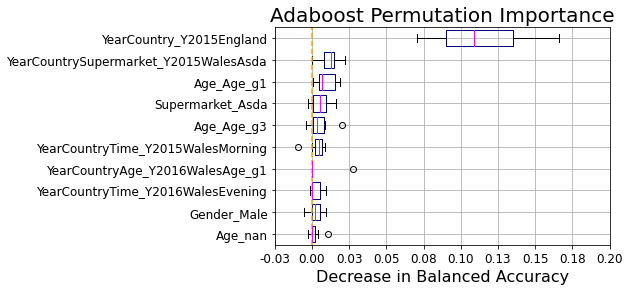

In [16]:
fig_box_pi_top10, ax_box_pi_top10 = plt.subplots()

perm_df_top10 = perm_df_ordered.iloc[:, 9::-1]
perm_df_top10.boxplot(ax = ax_box_pi_top10, 
                      widths = 0.75,
                      boxprops = {'color':'navy'}, 
                      medianprops = {'color':'magenta'}, 
                      whiskerprops = {'color':'black'}, 
                      vert = False)

ax_box_pi_top10.set_xticks(ax_box_pi_top10.get_xticks())
ax_box_pi_top10.set_yticks(ax_box_pi_top10.get_yticks())

xticks_pi_top10 = ax_box_pi_top10.get_xticks()
xticklabels_pi_top10 = [f"{x:.2f}" for x in xticks_pi_top10]

ax_box_pi_top10.set_xticklabels(xticklabels_pi_top10, fontsize = 12)
ax_box_pi_top10.set_yticklabels(ax_box_pi_top10.get_yticklabels(), fontsize = 12)

ax_box_pi_top10.set_xlabel("Decrease in Balanced Accuracy", 
                            fontsize = 16) 
#ax_box_pi_top10.set_ylabel("Feature Importance", fontsize = 12)
ax_box_pi_top10.set_title("Adaboost Permutation Importance", fontsize = 20)

ax_box_pi_top10.axvline(x = 0, 
                        color = "orange", 
                        linestyle = "dashed")

fig_box_pi_top10.set_size_inches([6, 4])

# save_figures
if save_figures:
    fig_name = f"{figure_path}Permutation Importance Top 10"
    fig_box_pi_top10.savefig(f"{fig_name}.pdf", 
                              dpi = 300, 
                              bbox_inches="tight")
    fig_box_pi_top10.savefig(f"{fig_name}.png", 
                              dpi = 300, 
                              bbox_inches="tight")
    fig_box_pi_top10.savefig(f"{fig_name}.svg", 
                              dpi = 300, 
                              bbox_inches="tight")

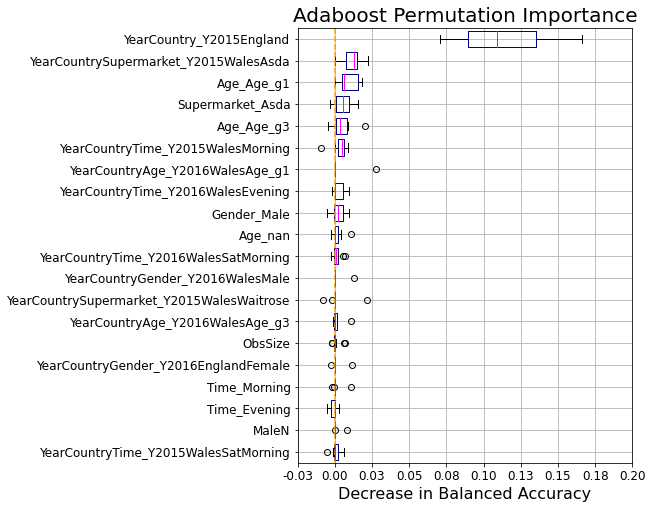

In [18]:
fig_box_pi_top20, ax_box_pi_top20 = plt.subplots()

perm_df_top20 = perm_df_ordered.iloc[:, 19::-1]
perm_df_top20.boxplot(ax = ax_box_pi_top20, 
                      widths = 0.75,
                      boxprops = {'color':'navy'}, 
                      medianprops = {'color':'magenta'}, 
                      whiskerprops = {'color':'black'}, 
                      vert = False)

ax_box_pi_top20.set_xticks(ax_box_pi_top20.get_xticks())
ax_box_pi_top20.set_yticks(ax_box_pi_top20.get_yticks())

xticks_pi_top20 = ax_box_pi_top20.get_xticks()
xticklabels_pi_top20 = [f"{x:.2f}" for x in xticks_pi_top20]

ax_box_pi_top20.set_xticklabels(xticklabels_pi_top20, fontsize = 12)
ax_box_pi_top20.set_yticklabels(ax_box_pi_top20.get_yticklabels(), fontsize = 12)

ax_box_pi_top20.set_xlabel("Decrease in Balanced Accuracy", 
                            fontsize = 16) 
#ax_box_pi_top20.set_ylabel("Feature Importance", fontsize = 12)
ax_box_pi_top20.set_title("Adaboost Permutation Importance", fontsize = 20)

ax_box_pi_top20.axvline(x = 0, 
                        color = "orange", 
                        linestyle = "dashed")

fig_box_pi_top20.set_size_inches([6, 8])

# save_figures
if save_figures:
    fig_name = f"{figure_path}Permutation Importance Top 20"
    fig_box_pi_top20.savefig(f"{fig_name}.pdf", 
                              dpi = 300, 
                              bbox_inches="tight")
    fig_box_pi_top20.savefig(f"{fig_name}.png", 
                              dpi = 300, 
                              bbox_inches="tight")
    fig_box_pi_top20.savefig(f"{fig_name}.svg", 
                              dpi = 300, 
                              bbox_inches="tight")

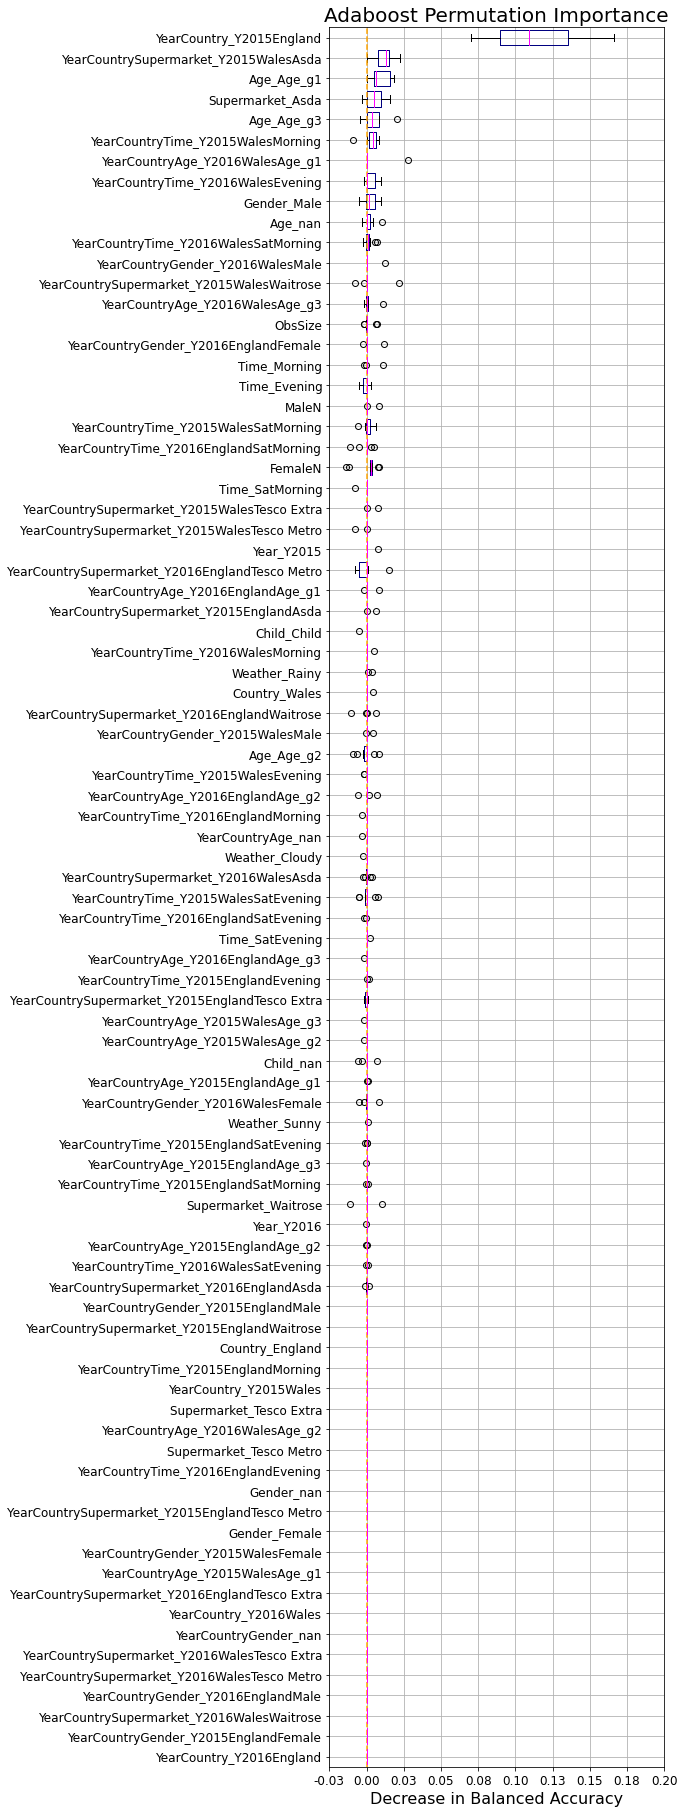

In [20]:
fig_box_pi_all85, ax_box_pi_all85 = plt.subplots()

perm_df_all85 = perm_df_ordered.iloc[:, ::-1]
perm_df_all85.boxplot(ax = ax_box_pi_all85, 
                      widths = 0.75,
                      boxprops = {'color':'navy'}, 
                      medianprops = {'color':'magenta'}, 
                      whiskerprops = {'color':'black'}, 
                      vert = False)

ax_box_pi_all85.set_xticks(ax_box_pi_all85.get_xticks())
ax_box_pi_all85.set_yticks(ax_box_pi_all85.get_yticks())

xticks_pi_all85 = ax_box_pi_all85.get_xticks()
xticklabels_pi_all85 = [f"{x:.2f}" for x in xticks_pi_all85]

ax_box_pi_all85.set_xticklabels(xticklabels_pi_all85, fontsize = 12)
ax_box_pi_all85.set_yticklabels(ax_box_pi_all85.get_yticklabels(), fontsize = 12)

ax_box_pi_all85.set_xlabel("Decrease in Balanced Accuracy", 
                            fontsize = 16) 
#ax_box_pi_all85.set_ylabel("Feature Importance", fontsize = 12)
ax_box_pi_all85.set_title("Adaboost Permutation Importance", fontsize = 20)

ax_box_pi_all85.axvline(x = 0, 
                        color = "orange", 
                        linestyle = "dashed")

fig_box_pi_all85.set_size_inches([6, 32])

# save_figures
if save_figures:
    fig_name = f"{figure_path}Permutation Importance All 85"
    fig_box_pi_all85.savefig(f"{fig_name}.pdf", 
                              dpi = 300, 
                              bbox_inches="tight")
    fig_box_pi_all85.savefig(f"{fig_name}.png", 
                              dpi = 300, 
                              bbox_inches="tight")
    fig_box_pi_all85.savefig(f"{fig_name}.svg", 
                              dpi = 300, 
                              bbox_inches="tight")